# Random Forest Regression to Forecast Merchant Monthly Revenue
This notebook will cover the RF modelling employed to create an overall merchant ranking by their projected monthly revenue.

In [45]:
# Initialise a spark session
import pandas as pd
from collections import Counter
import os
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


spark = (
    SparkSession.builder.appName("RF Model")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "16g")  # Increase driver memory
    .config("spark.executor.memory", "16g")  # Increase executor memory
    .config("spark.executor.instances", "4")  # Increase the number of executor instances
    .config("spark.driver.maxResultSize", "4g")
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()
)

24/10/01 14:37:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [46]:
spark.catalog.clearCache()


In [47]:
# Read transaction file
transactions = spark.read.parquet('../data/curated/flagged_fraud')
transactions = transactions.filter(F.col("is_fraud") != True)

In [48]:
transactions.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- year_week: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- fraud_probability_consumer: double (nullable = true)
 |-- name_consumer: string (nullable = true)
 |-- address_consumer: string (nullable = true)
 |-- state_consumer: string (nullable = true)
 |-- postcode_consumer: integer (nullable = true)
 |-- gender_consumer: string (nullable = true)
 |-- name_merchant: string (nullable = true)
 |-- fraud_probability_merchant: double (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- order_month_year: string (nullable = true)
 |-- SA4_CODE_2011: string (nullable = true)
 |-- SA4_NAME_2011: string (nullable = true)
 |-- unemployment_rate: string (nullable = true)
 |-- consumer_weekly_transaction: long (nullable = true)
 |-- merchant_weekly_transaction: long (nullable = true)
 |-- is_

### Feature Engineering

In [49]:
# Aggregating monthly revenue for each merchant
monthly_revenue_df = transactions.groupBy('merchant_abn', 'order_month_year').agg(
    F.sum('dollar_value').alias('monthly_revenue'),
    F.count('order_id').alias('transaction_count'),
    F.avg('fraud_probability_merchant').alias('avg_fraud_probability_merchant'),
    F.first('name_merchant').alias('merchant_name'),
    F.avg('take_rate').alias('avg_take_rate'),
    F.first('revenue_band').alias('revenue_band'),
    F.first('merchant_category').alias('merchant_category')
)
    
# Aggregating consumer-level features (most common state and gender for each merchant)

# Most common consumer state per merchant
consumer_state_mode = transactions.groupBy('merchant_abn', 'state_consumer').count() \
    .withColumn('row_num', F.row_number().over(Window.partitionBy('merchant_abn').orderBy(F.desc('count')))) \
    .filter(F.col('row_num') == 1) \
    .select('merchant_abn', 'state_consumer')

# Most common consumer gender per merchant
consumer_gender_mode = transactions.groupBy('merchant_abn', 'gender_consumer').count() \
    .withColumn('row_num', F.row_number().over(Window.partitionBy('merchant_abn').orderBy(F.desc('count')))) \
    .filter(F.col('row_num') == 1) \
    .select('merchant_abn', 'gender_consumer')

# Average Unemployment Rate per Merchant Month-Year
transactions = transactions.withColumn("unemployment_rate_numeric", F.col("unemployment_rate").cast("float"))

unemployment_agg = transactions.groupBy('merchant_abn', 'order_month_year').agg(
    F.avg('unemployment_rate_numeric').alias('avg_unemployment_rate')
)

In [50]:
# Joining Datasets
monthly_revenue_df = monthly_revenue_df.join(consumer_state_mode, on='merchant_abn', how='left') \
                                      .join(consumer_gender_mode, on='merchant_abn', how='left')

# Join with unemployment data on both 'merchant_abn' and 'order_month_year'
monthly_revenue_df = monthly_revenue_df.join(unemployment_agg, on=['merchant_abn', 'order_month_year'], how='left')

# Show the final dataframe
monthly_revenue_df.show(5)

+------------+----------------+------------------+-----------------+------------------------------+--------------------+-------------------+------------+--------------------+--------------+---------------+---------------------+
|merchant_abn|order_month_year|   monthly_revenue|transaction_count|avg_fraud_probability_merchant|       merchant_name|      avg_take_rate|revenue_band|   merchant_category|state_consumer|gender_consumer|avg_unemployment_rate|
+------------+----------------+------------------+-----------------+------------------------------+--------------------+-------------------+------------+--------------------+--------------+---------------+---------------------+
| 10023283211|          Feb-22| 48572.88260819351|              215|             56.06942278917232|       Felis Limited|0.18000000715255737|           e|furniture, home f...|           NSW|           Male|    71.28418544059576|
| 10023283211|          Oct-21|  70276.0243256525|              357|            55.89265

In [51]:
# Checking for Missing Values
nulls = monthly_revenue_df.agg(
    *(F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in monthly_revenue_df.columns)
)

# Show the result
nulls.show()

+------------+----------------+---------------+-----------------+------------------------------+-------------+-------------+------------+-----------------+--------------+---------------+---------------------+
|merchant_abn|order_month_year|monthly_revenue|transaction_count|avg_fraud_probability_merchant|merchant_name|avg_take_rate|revenue_band|merchant_category|state_consumer|gender_consumer|avg_unemployment_rate|
+------------+----------------+---------------+-----------------+------------------------------+-------------+-------------+------------+-----------------+--------------+---------------+---------------------+
|           0|               0|              0|                0|                             0|            0|            0|           0|                0|             0|              0|                    0|
+------------+----------------+---------------+-----------------+------------------------------+-------------+-------------+------------+-----------------+---------

In [52]:
# Creating lag features to include previous month's revenue
window_spec = Window.partitionBy('merchant_abn').orderBy('order_month_year')

# Lagging features: Previous month's revenue
monthly_revenue_df = monthly_revenue_df.withColumn(
    'previous_month_revenue', F.lag('monthly_revenue', 1).over(window_spec)
)

# Calculate revenue growth (percentage change)
monthly_revenue_df = monthly_revenue_df.withColumn(
    'revenue_growth',
    F.when(F.col('previous_month_revenue') > 0, 
           (F.col('monthly_revenue') - F.col('previous_month_revenue')) / F.col('previous_month_revenue'))
    .otherwise(F.lit(0))  # Fill with 0 if there is no previous revenue
)

# Fill NA values for first month with 0 (no previous data available)
monthly_revenue_df = monthly_revenue_df.fillna({'previous_month_revenue': 0, 'revenue_growth': 0})


monthly_revenue_df = monthly_revenue_df.fillna(0)  # Filling NA values for first month
monthly_revenue_df.show(5)

+------------+----------------+------------------+-----------------+------------------------------+-------------+-------------------+------------+--------------------+--------------+---------------+---------------------+----------------------+--------------------+
|merchant_abn|order_month_year|   monthly_revenue|transaction_count|avg_fraud_probability_merchant|merchant_name|      avg_take_rate|revenue_band|   merchant_category|state_consumer|gender_consumer|avg_unemployment_rate|previous_month_revenue|      revenue_growth|
+------------+----------------+------------------+-----------------+------------------------------+-------------+-------------------+------------+--------------------+--------------+---------------+---------------------+----------------------+--------------------+
| 10023283211|          Apr-21| 9221.405806871098|               47|             56.03849374950703|Felis Limited|0.18000000715255737|           e|furniture, home f...|           NSW|           Male|    74.

### Data Preparation

In [53]:
from pyspark.ml.feature import StandardScaler, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# StringIndexing categorical columns (merchant_tags, consumer_state, gender_consumer)
indexers = [
    StringIndexer(inputCol='state_consumer', outputCol='state_consumer_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='gender_consumer', outputCol='gender_consumer_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='merchant_category', outputCol='category_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='revenue_band', outputCol='revenue_band_indexed', handleInvalid='keep')
]

# OneHotEncoding indexed columns
encoders = [
    OneHotEncoder(inputCol='state_consumer_indexed', outputCol='state_consumer_encoded'),
    OneHotEncoder(inputCol='gender_consumer_indexed', outputCol='gender_consumer_encoded'),
    OneHotEncoder(inputCol='category_indexed', outputCol='category_encoded'),
    OneHotEncoder(inputCol='revenue_band_indexed', outputCol='revenue_band_encoded')
]

feature_cols = [
        'monthly_revenue', 'transaction_count', 'avg_fraud_probability_merchant', 'avg_unemployment_rate',
        'state_consumer_encoded', 'gender_consumer_encoded', 'revenue_growth', 'category_encoded', 'revenue_band_encoded',
        'avg_take_rate'
    ]

# VectorAssembler to combine numeric features into a single feature vector
assembler = VectorAssembler(inputCols= feature_cols, outputCol='features')

# Standardizing the numeric features
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')

pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])

# Fit the pipeline to the dataset
model_pipeline = pipeline.fit(monthly_revenue_df)

final_df = model_pipeline.transform(monthly_revenue_df)

final_df.select('merchant_abn', 'order_month_year', 'scaled_features').show(5)


+------------+----------------+--------------------+
|merchant_abn|order_month_year|     scaled_features|
+------------+----------------+--------------------+
| 10023283211|          Apr-21|(46,[0,1,2,3,4,11...|
| 10023283211|          Aug-21|(46,[0,1,2,3,4,11...|
| 10023283211|          Dec-21|(46,[0,1,2,3,4,11...|
| 10023283211|          Feb-22|(46,[0,1,2,3,4,11...|
| 10023283211|          Jan-22|(46,[0,1,2,3,4,11...|
+------------+----------------+--------------------+
only showing top 5 rows



### Training Model

In [54]:
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)

In [55]:
rf = RandomForestRegressor(featuresCol='scaled_features', labelCol='monthly_revenue', maxBins=32, maxDepth=10)
rf_model = rf.fit(train_data)
rf_model.write().overwrite().save("random_forest_model") # Save Model

# Make predictions on the test data
predictions = rf_model.transform(test_data)

predictions.select('merchant_abn', 'order_month_year', 'monthly_revenue', 'revenue_growth','prediction').show(5)

24/10/01 14:38:23 WARN DAGScheduler: Broadcasting large task binary with size 1067.2 KiB
24/10/01 14:38:23 WARN DAGScheduler: Broadcasting large task binary with size 1680.6 KiB
24/10/01 14:38:23 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


+------------+----------------+------------------+-------------------+------------------+
|merchant_abn|order_month_year|   monthly_revenue|     revenue_growth|        prediction|
+------------+----------------+------------------+-------------------+------------------+
| 10023283211|          Dec-21| 66067.74432316715| 3.1795241652322175| 72025.56940168532|
| 10023283211|          Jun-21|11078.327301762965|0.10239164872676397|10653.279799798496|
| 10023283211|          May-21|11953.898144671877| 0.3170441527012353|13514.826092088271|
| 10187291046|          Aug-21|1059.7535269884397|  5.158034850430842| 3952.332865789546|
| 10187291046|          Mar-21|  750.345554053667|  1.864485833032831|1757.3355927820314|
+------------+----------------+------------------+-------------------+------------------+
only showing top 5 rows



In [56]:
# Evaluation Metrics
evaluator = RegressionEvaluator(labelCol='monthly_revenue', predictionCol='prediction', metricName='rmse')

# Root Mean Squared Error (RMSE)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Compute the Normalized RMSE (NRMSE)
mean_target = predictions.select(F.mean('monthly_revenue')).first()[0]
print(f"Mean Target: {mean_target}")
nrmse = rmse / mean_target
print(f"Normalized RMSE (NRMSE): {nrmse}")


# R-squared
r2_evaluator = RegressionEvaluator(labelCol='monthly_revenue', predictionCol='prediction', metricName='r2')
r2 = r2_evaluator.evaluate(predictions)
print(f"R-squared: {r2}")

# Adjusted R-squared
n = predictions.count() 
p = len(feature_cols)  # Number of features (columns used in the model)
adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
print(f"Adjusted R-Squared: {adjusted_r2}")

Root Mean Squared Error (RMSE): 52375.84414440796


Mean Target: 30289.989237972983
Normalized RMSE (NRMSE): 1.7291470040783998


R-squared: 0.7037449371074169


Adjusted R-Squared: 0.7034167493785008


### Apply Hyperparameter Tuning and Cross Validation to Improve Model Performance
Note: This part of the code will take quite a long time to run due to the vast amount of data available. (Approximately 45 minutes)

In [16]:
# Applying Hyperparameter Tuning
rf = RandomForestRegressor(featuresCol='scaled_features', labelCol='monthly_revenue')

paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10, 15])  # Testing different values for maxDepth
             .addGrid(rf.numTrees, [20, 50, 100])  # Number of trees in the forest
             .addGrid(rf.maxBins, [32, 64])  # Testing different values for maxBins
             .build())

evaluator = RegressionEvaluator(labelCol='monthly_revenue', predictionCol='prediction', metricName='rmse')

crossval = CrossValidator(estimator=rf, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=5)  # 5-fold cross-validation

cv_model = crossval.fit(train_data)

predictions = cv_model.transform(test_data)

24/09/29 12:31:20 WARN DAGScheduler: Broadcasting large task binary with size 1135.5 KiB
24/09/29 12:31:21 WARN DAGScheduler: Broadcasting large task binary with size 1771.0 KiB
24/09/29 12:31:22 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/09/29 12:31:28 WARN DAGScheduler: Broadcasting large task binary with size 1128.5 KiB
24/09/29 12:31:29 WARN DAGScheduler: Broadcasting large task binary with size 1733.4 KiB
24/09/29 12:31:30 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/09/29 12:31:36 WARN DAGScheduler: Broadcasting large task binary with size 1397.7 KiB
24/09/29 12:31:37 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/09/29 12:31:39 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/09/29 12:31:41 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/09/29 12:31:43 WARN DAGScheduler: Broadcasting large task binary with size 1273.2 KiB
24/09/29 12:31:49 WARN DAGScheduler:

In [18]:
# Evaluation Metrics
evaluator = RegressionEvaluator(labelCol='monthly_revenue', predictionCol='prediction', metricName='rmse')

# Root Mean Squared Error (RMSE)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Compute the Normalized RMSE (NRMSE)
mean_target = predictions.select(F.mean('monthly_revenue')).first()[0]
print(f"Mean Target: {mean_target}")
nrmse = rmse / mean_target
print(f"Normalized RMSE (NRMSE): {nrmse}")


# R-squared
r2_evaluator = RegressionEvaluator(labelCol='monthly_revenue', predictionCol='prediction', metricName='r2')
r2 = r2_evaluator.evaluate(predictions)
print(f"R-squared: {r2}")

# Adjusted R-squared
n = predictions.count() 
p = len(feature_cols)  # Number of features (columns used in the model)
adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
print(f"Adjusted R-Squared: {adjusted_r2}")

Root Mean Squared Error (RMSE): 43289.52344325155


Mean Target: 30289.989237972983
Normalized RMSE (NRMSE): 1.4291693240016647


R-squared: 0.7976191947443473


Adjusted R-Squared: 0.7973949997678815


24/09/29 16:36:04 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 902655 ms exceeds timeout 120000 ms
24/09/29 16:36:04 WARN SparkContext: Killing executors is not supported by current scheduler.
24/09/29 16:36:12 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

Hyperparameter tuning did not improve the performance of the model based on the evaluation metrics. Additionally, the extensively long duration to run the hyperparameter tuning makes it inefficient. Therefore for the ranking system, the original random forest model will be used.

## Predicting Future Monthly Revenue

In [57]:
from pyspark.sql.types import DateType
from dateutil.relativedelta import relativedelta
from datetime import datetime

# Step 1: Parse the order_month_year column to a proper date format
monthly_revenue_df = monthly_revenue_df.withColumn(
    'order_month_year_date', F.to_date(F.concat(F.lit('01-'), F.col('order_month_year')), 'dd-MMM-yy')
)

# Get the most recent month per merchant
window_spec = Window.partitionBy('merchant_abn').orderBy(F.desc('order_month_year_date'))
latest_merchant_data = monthly_revenue_df.withColumn('row_num', F.row_number().over(window_spec)) \
                                         .filter(F.col('row_num') == 1) \
                                         .drop('row_num')

In [58]:
next_month = 'Aug-24'
future_month_df = spark.createDataFrame([(next_month,)], ['future_order_month_year'])
future_data = latest_merchant_data.crossJoin(future_month_df)

In [59]:
future_data.show(5)

+------------+----------------+-----------------+-----------------+------------------------------+--------------------+-------------------+------------+--------------------+--------------+---------------+---------------------+----------------------+--------------------+---------------------+-----------------------+
|merchant_abn|order_month_year|  monthly_revenue|transaction_count|avg_fraud_probability_merchant|       merchant_name|      avg_take_rate|revenue_band|   merchant_category|state_consumer|gender_consumer|avg_unemployment_rate|previous_month_revenue|      revenue_growth|order_month_year_date|future_order_month_year|
+------------+----------------+-----------------+-----------------+------------------------------+--------------------+-------------------+------------+--------------------+--------------+---------------+---------------------+----------------------+--------------------+---------------------+-----------------------+
| 10023283211|          Feb-22|48572.88260819351|

In [60]:
future_data = model_pipeline.transform(future_data)
future_data = rf_model.transform(future_data)
future_predictions = future_data.select('merchant_abn', 'merchant_name', 'merchant_category', 'future_order_month_year', 'prediction')
future_predictions = future_predictions.withColumnRenamed('prediction', 'projected_revenue')
future_predictions.show(5)

+------------+--------------------+--------------------+-----------------------+------------------+
|merchant_abn|       merchant_name|   merchant_category|future_order_month_year| projected_revenue|
+------------+--------------------+--------------------+-----------------------+------------------+
| 10023283211|       Felis Limited|furniture, home f...|                 Aug-24|52429.438117199694|
| 10142254217|Arcu Ac Orci Corp...|cable, satellite,...|                 Aug-24|11980.977099908278|
| 10187291046|Ultricies Digniss...|watch, clock, and...|                 Aug-24|3286.3048568611302|
| 10192359162| Enim Condimentum PC|music shops - mus...|                 Aug-24|10820.661621467405|
| 10206519221|       Fusce Company|gift, card, novel...|                 Aug-24|13580.493861057894|
+------------+--------------------+--------------------+-----------------------+------------------+
only showing top 5 rows



In [61]:
RF_predictions = future_predictions.orderBy(F.col('projected_revenue').desc())

# Show the top 10 merchants by predicted revenue
RF_predictions.show(10)

+------------+--------------------+--------------------+-----------------------+-----------------+
|merchant_abn|       merchant_name|   merchant_category|future_order_month_year|projected_revenue|
+------------+--------------------+--------------------+-----------------------+-----------------+
| 86578477987|   Leo In Consulting|watch, clock, and...|                 Aug-24| 855832.058105619|
| 52959528548|   Libero Et Limited|furniture, home f...|                 Aug-24|715938.8988212582|
| 90543168331|Phasellus Dapibus...|furniture, home f...|                 Aug-24|645760.7347991553|
| 94493496784|Dictum Phasellus ...|gift, card, novel...|                 Aug-24|634957.5653998953|
| 32361057556|Orci In Consequat...|gift, card, novel...|                 Aug-24|634380.6671976116|
| 89726005175| Est Nunc Consulting|tent and awning s...|                 Aug-24|630051.0543222269|
| 79417999332|Phasellus At Company|gift, card, novel...|                 Aug-24|627062.5049039533|
| 35909341

## Export Ranked Data

In [62]:
RF_predictions = RF_predictions.limit(100)

# Add Index Column for Rank Number
window = Window.orderBy(F.desc("projected_revenue"))
RF_ranking = RF_predictions.withColumn("RF_rank", F.row_number().over(window))

RF_ranking.write.parquet('../data/curated/RF_ranking')

24/10/01 14:39:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/01 14:39:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/01 14:39:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/01 14:39:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/01 14:39:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/01 14:39:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/01 1

## Evaluating Model

In [63]:
importances = rf_model.featureImportances
importance_values = importances.toArray()

In [64]:
# Fit the StringIndexer on your data
indexers = [
    StringIndexer(inputCol='state_consumer', outputCol='state_consumer_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='gender_consumer', outputCol='gender_consumer_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='merchant_category', outputCol='category_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='revenue_band', outputCol='revenue_band_indexed', handleInvalid='keep')
]

indexer_models = [indexer.fit(monthly_revenue_df) for indexer in indexers]

# Get the actual number of categories for each categorical column
for indexer_model in indexer_models:
    print(f"Column: {indexer_model.getInputCol()} - Number of Categories: {len(indexer_model.labels)}")

Column: state_consumer - Number of Categories: 7
Column: gender_consumer - Number of Categories: 3
Column: merchant_category - Number of Categories: 25
Column: revenue_band - Number of Categories: 5


In [65]:
vec_assembler_stage = model_pipeline.stages[-2]
encoded_feature_cols = vec_assembler_stage.getInputCols()

onehot_encoded_sizes = {
    'state_consumer_encoded': 7,  # Update with the actual number of categories
    'gender_consumer_encoded': 3,  # Update with the actual number of categories
    'category_encoded': 25,  # Update with actual number
    'revenue_band_encoded':5  # Update with actual number
}

# Flatten the encoded features (e.g., one-hot encoded columns)
expanded_feature_cols = []
for col in encoded_feature_cols:
    if col in onehot_encoded_sizes:
        expanded_feature_cols.extend([f'{col}_{i}' for i in range(onehot_encoded_sizes[col])])
    else:
        expanded_feature_cols.append(col)

In [66]:
feature_importance_df = pd.DataFrame({
    'Feature': expanded_feature_cols,
    'Importance': importance_values
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

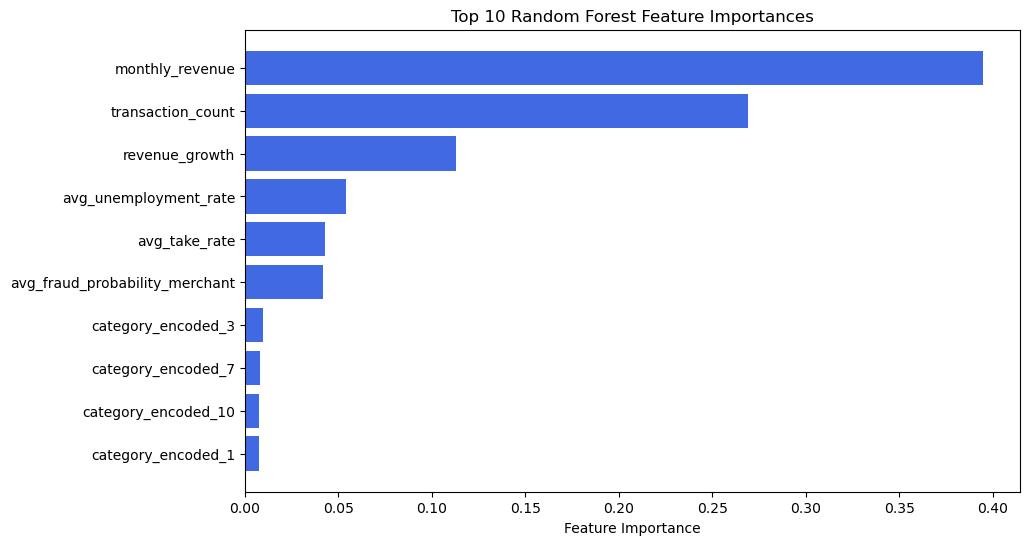

In [67]:
import matplotlib.pyplot as plt

# Sort the features by importance and take the top 10
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='royalblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Random Forest Feature Importances')
plt.gca().invert_yaxis()  # To have the highest importance on top
plt.show()

In [68]:
# Explore which category is referred to in feature importance
category_indexer_model = indexer_models[2]

# Get the list of categories
category_labels = category_indexer_model.labels

print(f"Category for category_encoded_3: {category_labels[2]}")
print(f"Category for category_encoded_7: {category_labels[7]}")
print(f"Category for category_encoded_10: {category_labels[10]}")
print(f"Category for category_encoded_1: {category_labels[1]}")


Category for category_encoded_3: computer programming , data processing, and integrated systems design services
Category for category_encoded_7: florists supplies, nursery stock, and flowers
Category for category_encoded_10: furniture, home furnishings and equipment shops, and manufacturers, except appliances
Category for category_encoded_1: digital goods: books, movies, music


In [69]:
spark.stop()